In [1]:
import torch
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from botorch.models.gpytorch import GPyTorchModel
from botorch.models import ModelListGP
from botorch.fit import fit_gpytorch_mll, fit_gpytorch_mll_torch
from botorch.acquisition.multi_objective import qLogExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions import FastNondominatedPartitioning
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective import is_non_dominated
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import SumMarginalLogLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, ConstantKernel
from gpytorch.constraints import Interval
from gpytorch.models import ExactGP, ApproximateGP
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from botorch.test_functions import BraninCurrin, ZDT3
from botorch.test_functions.multi_objective import MultiObjectiveTestProblem
from botorch.utils import draw_sobol_samples
from sklearn.preprocessing import StandardScaler

c:\Users\aatus\ohjelmointi\BOMP\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GPLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128):
        inducing_points = torch.randn(output_dims, num_inducing, input_dims)
        variational_distribution = CholeskyVariationalDistribution(num_inducing_points=num_inducing)

        variational_strategy = VariationalStrategy(
            ApproximateGP(inducing_points),
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy, input_dims, output_dims)

        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        cov = self.covar_module(x)
        return MultivariateNormal(mean, cov)

class DGPModel(DeepGP, GPyTorchModel):
    def __init__(self, input_dim, hidden_dim=32, output_dim=None):
        output_dim = input_dim if output_dim is None else output_dim
        self.layer1 = GPLayer(input_dim, hidden_dim)
        self.layer2 = GPLayer(hidden_dim, output_dim)

        super().__init__()

        self.hidden_layer = self.layer1
        self.last_layer = self.layer2

    def forward(self, inputs):
        x = self.hidden_layer(inputs)
        x = x.rsample()
        return self.last_layer(x)

    def predict(self, x):
        self.eval()
        self.likelihood.eval()
        with torch.no_grad():
            preds = self.likelihood(self(x))
        return preds.mean, preds.variance


In [31]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import gpytorch
from torch.optim import Adam
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, DeepApproximateMLL
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from botorch.test_functions import Branin

In [21]:
n = 1000
X = torch.rand((n, 2))
problem = Branin()
bounds = problem._bounds
X[:, 0] = X[:, 0] * (bounds[0][1] - bounds[0][0]) + bounds[0][0]
X[:, 1] = X[:, 1] * (bounds[1][1] - bounds[1][0]) + bounds[1][0]
y = problem.evaluate_true(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

In [36]:
class DeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims=None, num_inducing=256):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims).double()
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims).double()
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(num_inducing_points=num_inducing, batch_shape=batch_shape)
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)

        super().__init__(variational_strategy, input_dims, output_dims)

        self.mean_module = ConstantMean(batch_shape=batch_shape)
        self.covar_module = ScaleKernel(RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


class DeepGP(DeepGP):
    def __init__(self, input_dim, hidden_dim=3, output_dim=None):
        super().__init__()

        # self.feature_extractor = FeatureExtractor(input_dim, hidden_dim=32, n_hidden=2)

        self.input_layer = DeepGPHiddenLayer(input_dims=input_dim, output_dims=hidden_dim)
        self.hidden_layer1 = DeepGPHiddenLayer(input_dims=hidden_dim, output_dims=hidden_dim)
        # self.hidden_layer2 = DeepGPHiddenLayer(input_dims=hidden_dim, output_dims=hidden_dim)
        self.last_layer = DeepGPHiddenLayer(input_dims=hidden_dim, output_dims=output_dim)

        self.likelihood = GaussianLikelihood()

    def forward(self, x):
        # x = self.feature_extractor(x)
        
        x = self.input_layer(x)
        x = self.hidden_layer1(x)
        # x = self.hidden_layer2(x)
        return self.last_layer(x)

    def predict(self, X_test):
        with torch.no_grad():
            with gpytorch.settings.num_likelihood_samples(50):  # Sample 50 points from the posterior and take the mean values
                preds = self.likelihood(self(X_test))
        return preds.mean.mean(dim=0), preds.variance.mean(dim=0)


In [38]:
model = DeepGP(X_train.shape[1], hidden_dim=4, output_dim=None).double()
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, len(X_train))).double()
history = []
optimizer = Adam(model.parameters(), lr=0.01)

In [39]:
n_iter = 1000
num_samples = 3  # effects the speed by quite a lot, but not the stability as much

for i in range(n_iter):
    optimizer.zero_grad()
    with gpytorch.settings.num_likelihood_samples(num_samples):
        output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    print(f"Iter {i + 1} - Loss: {loss.item()}")
    history.append(loss.item())
    optimizer.step()


Iter 1 - Loss: 3998.531743494159
Iter 2 - Loss: 3967.8673713652
Iter 3 - Loss: 3937.349498890661
Iter 4 - Loss: 3907.122993006616
Iter 5 - Loss: 3877.043846490889
Iter 6 - Loss: 3847.218627135869
Iter 7 - Loss: 3817.7741081171025
Iter 8 - Loss: 3787.761723365608
Iter 9 - Loss: 3758.82345689839
Iter 10 - Loss: 3729.6061535980866
Iter 11 - Loss: 3699.9569901108225
Iter 12 - Loss: 3670.9322906717166
Iter 13 - Loss: 3642.7899617815674
Iter 14 - Loss: 3612.8997996644125
Iter 15 - Loss: 3583.591084006943
Iter 16 - Loss: 3555.048270003235
Iter 17 - Loss: 3526.3200585617597
Iter 18 - Loss: 3495.860926578052
Iter 19 - Loss: 3465.723514734052
Iter 20 - Loss: 3438.577420678352
Iter 21 - Loss: 3406.3027967609173
Iter 22 - Loss: 3376.766486546958
Iter 23 - Loss: 3349.1145446480436
Iter 24 - Loss: 3315.724388091899
Iter 25 - Loss: 3285.603995724972
Iter 26 - Loss: 3256.775684765062
Iter 27 - Loss: 3223.993272682356
Iter 28 - Loss: 3192.495179133961
Iter 29 - Loss: 3162.926498585783
Iter 30 - Loss: 3

RMSE: 9.429150632875542


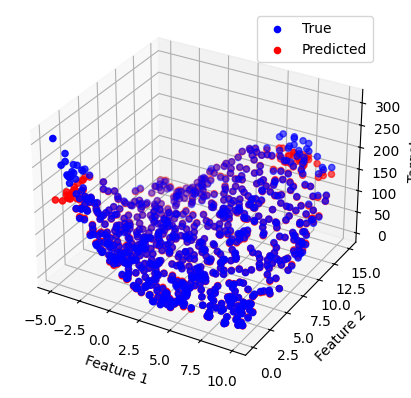

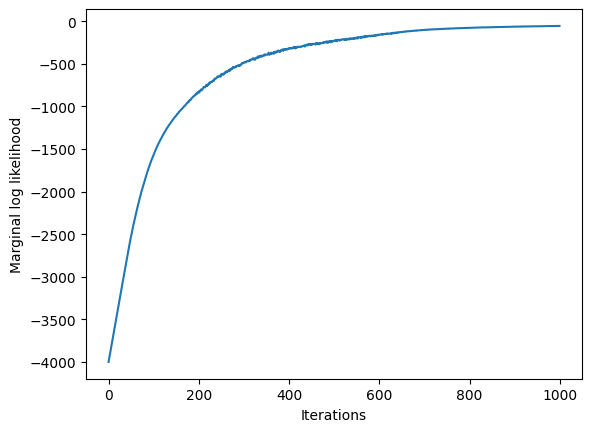

In [40]:
model.eval()
means, variances = model.predict(X_test)

print(f"RMSE: {root_mean_squared_error(y_test, means)}")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, label="True", color='blue')
ax.scatter(X_test[:, 0], X_test[:, 1], means, label="Predicted", color='red')
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Target")
ax.legend()

plt.figure()
plt.plot(-np.array(history))
plt.ylabel("Marginal log likelihood")
plt.xlabel("Iterations")
plt.show()

In [ ]:
from botorch.acquisition.multi_objective import qLogExpectedHypervolumeImprovement
from botorch.sampling import SobolQMCNormalSampler

sampler = SobolQMCNormalSampler(torch.Size([256]))
objective = qLogExpectedHypervolumeImprovement(model, )
qneivalues = qNEI(test_x.unsqueeze(-2))